In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf


In [2]:
# reading cleaned data
data = pd.read_excel("Output Data/Main Data.xlsx")
Symbol_indexes=data['Symbol']
# Saving the Labels 
Y_labels=np.array(data[['Close/Last Classification','Close Label']].value_counts().index)

# Droping string columns
data.drop(columns=['Symbol','Close/Last Classification'],axis=1, inplace=True)

#Creating a data frame to record the results of baseline and model tuning
Results=pd.DataFrame({'Parameters':[],'Train Accuracy/MSE':[],'Test Accuracy/R2':[],'Precision/RMSE':[],'Recall':[],'f Measure':[],'Data':[],'Comment':[]})

In [255]:
Results

,Parameters,Train Accuracy/MSE,Test Accuracy/R2,Precision/RMSE,Recall,f Measure,Data,Comment


Data Selection

In [256]:
data

,Close Label,Close/Last,Date,Day,EBIDTA in millions,EPS,FEDFUNDS,GDP,Month,Oil-Open,Oil-Volume Lagged,Steel Production,Symbol_label,Unemployment Rate,Volume Lagged,YC Ratio Wallstreet,YC Ratio arturo
0,0,53.590000,2014-01-03,3,918,0.56,0.07,17550.68,1,95.47,234933,106.6961,0,6.6,3475200,2.60,2.94
1,0,53.400002,2014-01-06,6,918,0.56,0.07,17550.68,1,94.18,196347,106.6961,0,6.6,3195400,2.58,2.93
2,0,52.790001,2014-01-07,7,918,0.56,0.07,17550.68,1,93.60,172625,106.6961,0,6.6,2940300,2.56,2.92
3,0,52.209999,2014-01-08,8,918,0.56,0.07,17550.68,1,93.96,159884,106.6961,0,6.6,4494200,2.58,2.96
4,0,51.820000,2014-01-09,9,918,0.56,0.07,17550.68,1,92.58,215605,106.6961,0,6.6,5122500,2.53,2.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15535,1,43.840000,2021-12-23,23,8410,-0.12,0.08,23315.08,12,73.03,295571,101.0145,8,3.9,3264642,0.79,1.43
15536,1,44.330000,2021-12-27,27,8410,-0.12,0.08,23315.08,12,73.38,253529,101.0145,8,3.9,3037950,0.72,1.42
15537,0,44.020000,2021-12-28,28,8410,-0.12,0.08,23315.08,12,75.97,253684,101.0145,8,3.9,2860791,0.75,1.43
15538,0,43.680000,2021-12-29,29,8410,-0.12,0.08,23315.08,12,76.04,239539,101.0145,8,3.9,3656423,0.80,1.50


In [257]:
# Sorting the data set by date
data=data.sort_values(by=['Date'],ascending=True).reset_index(drop=True)

In [258]:
data.columns

Index(['Close Label', 'Close/Last', 'Date', 'Day', 'EBIDTA in millions', 'EPS',
       'FEDFUNDS', 'GDP', 'Month', 'Oil-Open', 'Oil-Volume Lagged',
       'Steel Production', 'Symbol_label', 'Unemployment Rate',
       'Volume Lagged', 'YC Ratio Wallstreet', 'YC Ratio arturo'],
      dtype='object')

In [259]:
data.shape

(15540, 17)

In [41]:
# creating list of columns to be tried as new data
new_columns=['YC Ratio Wallstreet','Steel Production','YC Ratio arturo','Oil-Open','Oil-Volume Lagged']

## Classification

In [261]:
# Checking Target label distribution for classification problem
str(round(data['Close Label'].value_counts()[0].sum()/data['Close Label'].value_counts().sum()*100,3))+"%"

'50.946%'

In [3]:
# Target data seperation 
Y_classification=data[['Close Label']]
# feaature seperation
base_X_classification=data[data.columns.difference(['Close/Last','Close Label','YC Ratio Wallstreet','Steel Production','YC Ratio arturo','Date','Year','Oil-Open','Oil-Volume Lagged'])]

In [263]:
base_X_classification.head(2)

,Day,EBIDTA in millions,EPS,FEDFUNDS,GDP,Month,Symbol_label,Unemployment Rate,Volume Lagged
0,3,918,0.56,0.07,17550.68,1,0,6.6,3475200
1,3,3196,1.25,0.07,17550.68,1,5,6.6,4958126


In [264]:
data[new_columns].head(2)

,YC Ratio Wallstreet,Steel Production,YC Ratio arturo,Oil-Open,Oil-Volume Lagged
0,2.6,106.6961,2.94,95.47,234933
1,2.6,106.6961,2.94,95.47,234933


In [265]:
data[new_columns].head(2).shape

(2, 5)

In [266]:
Y_classification.head(2)

,Close Label
0,0
1,0


### SVC

,Parameters,Train Accuracy/MSE,Test Accuracy/R2,Precision/RMSE,Recall,f Measure,Data,Comment
1,SVC,0.569038,0.51952,0.491541,0.487971,0.489749,Base Data-Base SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."


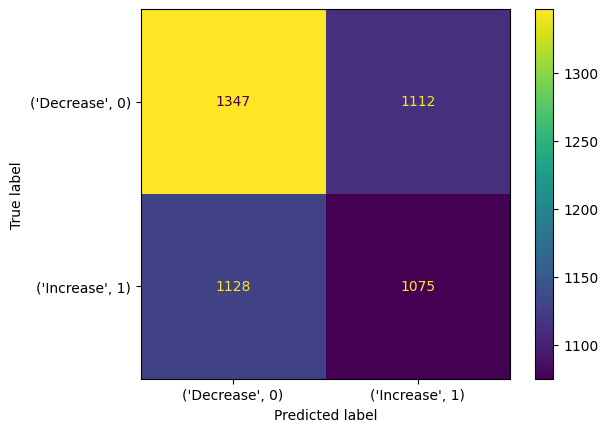

In [267]:
# Procedure encapsulating Baseline SVC model 
def Baseline_SVC(X,Y,Comment,HP):

    # test train split
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=19)

    # defining scaler
    scaler = StandardScaler()

    # changing the shape of train and test splits
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Standardizing the data using standard scaler
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    #  defining model 
    if HP==False:
        svm_model_tuned= SVC()
    else:
        svm_model_tuned= SVC(C= 1.0, break_ties= False, cache_size= 200, class_weight= None, coef0= 0.0, decision_function_shape= 'ovr', degree= 3, gamma= 'scale', kernel= 'rbf', max_iter= -1, probability= False, random_state= None, shrinking= True, tol= 0.001, verbose= False)
    # fitting data to model
    svm_model_tuned.fit(x_train, y_train)

    # predicting using unknown data 
    y_pred = svm_model_tuned.predict(x_test)

    # classification_report_output = classification_report(y_test, y_pred)
    Test_accuracy=metrics.accuracy_score(y_test,y_pred) # Storing test data accuracy to a variable for result recording     
    training_accuracy=metrics.accuracy_score(y_train,svm_model_tuned.predict(x_train))  # checking train accuracy
    Precision=metrics.precision_score(y_test,y_pred) # Calculating the test data predictions precision  
    Recall=metrics.recall_score(y_test,y_pred)  # Calculating the Recall for test data prediction
    f_measure= (2*Precision)*Recall/(Precision+Recall)
    
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(cm, annot=True, fmt="d", 
    # xticklabels=["Predicted 0", "Predicted 1"],
    # yticklabels=["Actual 0", "Actual 1"])

    # plt.title("Confusion Matrix")
    # plt.show()
    disp = ConfusionMatrixDisplay(metrics.confusion_matrix(y_test,y_pred),display_labels=Y_labels)
    disp.plot()
    # plt.show()
    
    i=Results.shape[0]+1  

    # Storing output to Results dataframe
    Results.loc[i]=['SVC',training_accuracy,Test_accuracy,Precision,Recall,f_measure,Comment,svm_model_tuned.get_params()]     # storing the results
    return y_pred
# calling baseline model with baseline data
Baseline_SVC(base_X_classification,Y_classification,"Base Data-Base SVC",'')
# showing results of baseline model with base data 
Results.tail(1)

,Parameters,Train Accuracy/MSE,Test Accuracy/R2,Precision/RMSE,Recall,f Measure,Data,Comment
1,SVC,0.569038,0.519520,0.491541,0.487971,0.489749,Base Data-Base SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
2,SVC,0.527578,0.530459,0.542325,0.410859,0.467526,Base Data-Gridsearch model SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."


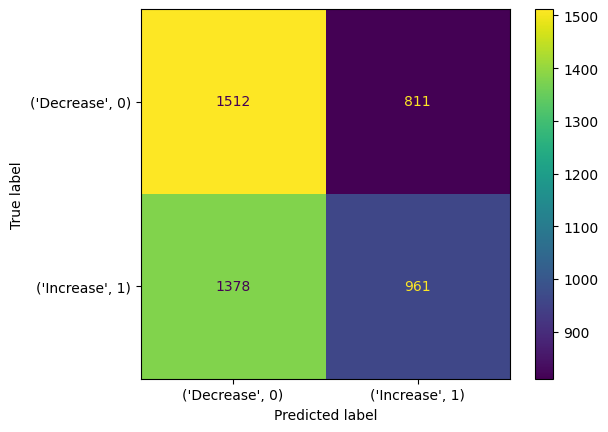

In [268]:
def HyperParam_SVC(X,Y,Comment):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    
    # scaler = MinMaxScaler(feature_range=(0, 1))

    # defining scaler
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    #  changing the shape of train and test splits
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    #  defining model 
    svm_model = SVC(random_state=42)

    max_iter_=range(10,20)
    # setting hyper parameters 
    hyperparamter=[{'C': [1.0],'break_ties': [False],'cache_size': [200],'class_weight': [None],'coef0': [0.0],'decision_function_shape': ['ovr'],'degree': [3],'gamma': ['scale'],
    'kernel': ['rbf','linear'],'max_iter': [-1],'probability': [False],'random_state': [None],'shrinking': [True],'tol': [0.001],'verbose': [False]}]
    # hyperparamter=[{'kernel':[ 'rbf', 'sigmoid','linear','poly'],'max_iter':max_iter_,'C':[1,0.1,0.9]}] 
    # Applying hyper paramters to grid search
    Optimized_param_model_SVM=GridSearchCV(svm_model,param_grid=hyperparamter,scoring='accuracy',cv=5,return_train_score=True)  

    # training grid search model 
    Optimized_param_model_SVM.fit(x_train, y_train)

    Best_combination=Optimized_param_model_SVM.best_params_  # storing the best paramters into variable for results recording
    training_cv_score=Optimized_param_model_SVM.best_score_  # storing train datas crosss validation score into a variable or results recording   
    y_pred=Optimized_param_model_SVM.best_estimator_.predict(x_test)# using grid search model to predict the target of x_test (test features)

    Test_accuracy=metrics.accuracy_score(y_test,y_pred) # Storing test data accuracy to a variable for result recording     
    Precision=metrics.precision_score(y_test,y_pred) # Calculating the test data predictions precision  
    Recall=metrics.recall_score(y_test,y_pred)  # Calculating the Recall for test data prediction
    f_measure= (2*Precision)*Recall/(Precision+Recall)

    disp = ConfusionMatrixDisplay(metrics.confusion_matrix(y_test,y_pred),display_labels=Y_labels)
    disp.plot()

    i=Results.shape[0]+1  

    Results.loc[i]=['SVC',training_cv_score,Test_accuracy,Precision,Recall,f_measure,Comment,Best_combination]     # storing the results

    # cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
    # disp = ConfusionMatrixDisplay(metrics.confusion_matrix(y_test,y_pred),display_labels=Y_labels)
    # disp.plot()
    # plt.show()

    # Results

HyperParam_SVC(base_X_classification,Y_classification,"Base Data-Gridsearch model SVC")
Results.tail(2)

In [269]:
SVC_final_HP=Results[Results['Data']=='Base Data-Gridsearch model SVC']['Comment'].values[0]
str(SVC_final_HP).replace("'",'').replace("{",'').replace("}",'').replace(":",'=')

'C= 1.0, break_ties= False, cache_size= 200, class_weight= None, coef0= 0.0, decision_function_shape= ovr, degree= 3, gamma= scale, kernel= rbf, max_iter= -1, probability= False, random_state= None, shrinking= True, tol= 0.001, verbose= False'

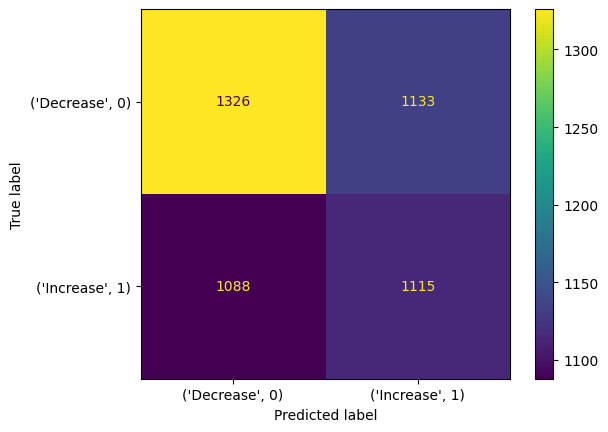

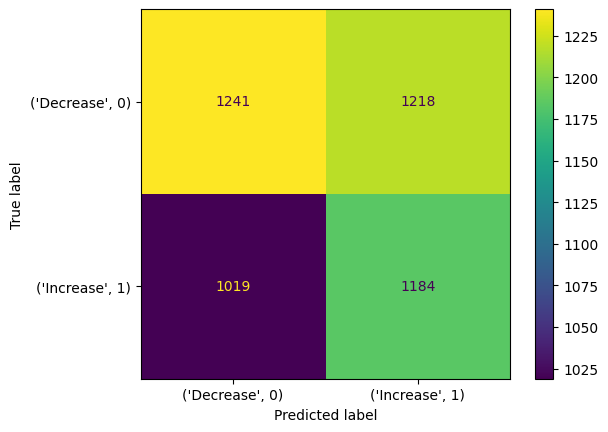

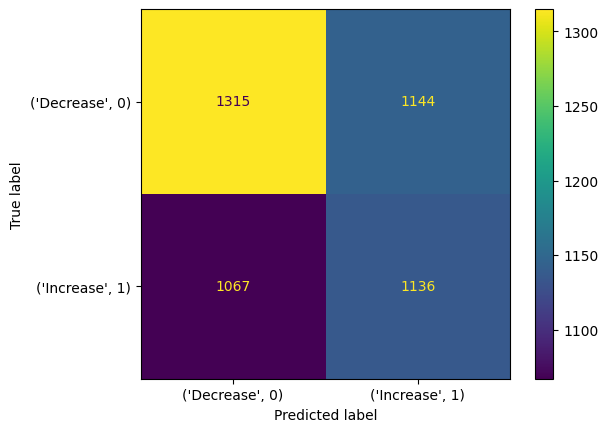

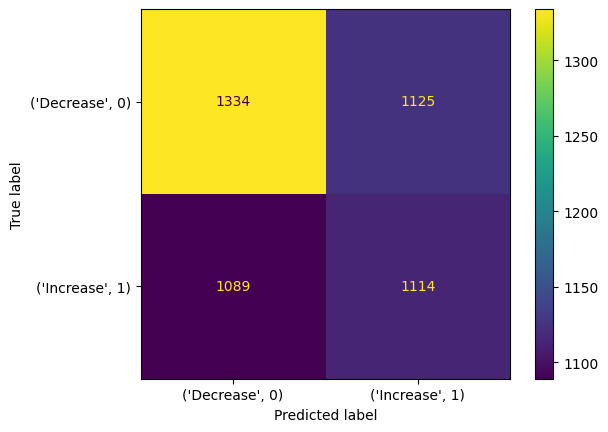

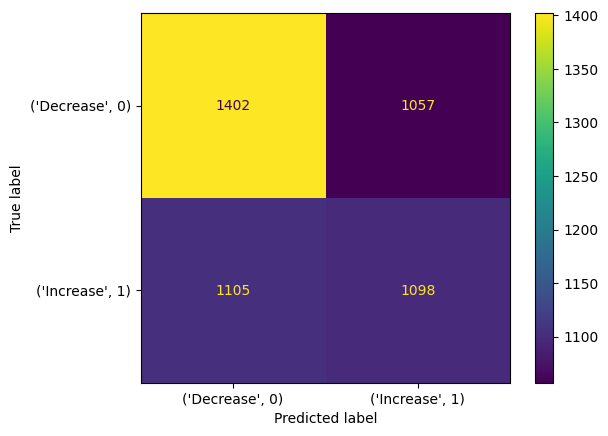

In [270]:
# using for loop to add each columns impact on prediction (individual columns only)
for new_data in new_columns:
    # adding column data to the baseline lineset
    tempdf= pd.concat([base_X_classification,data[[new_data]]],axis=1)
    # testing model performance with newly added data
    Baseline_SVC(tempdf,Y_classification,new_data,True)

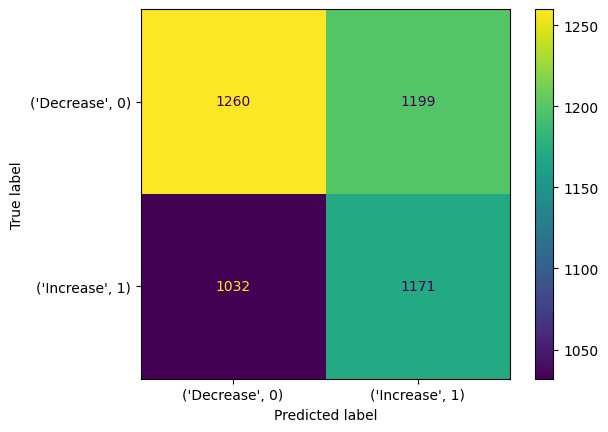

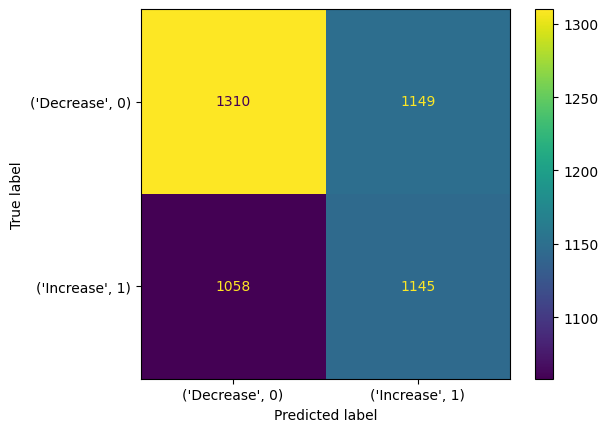

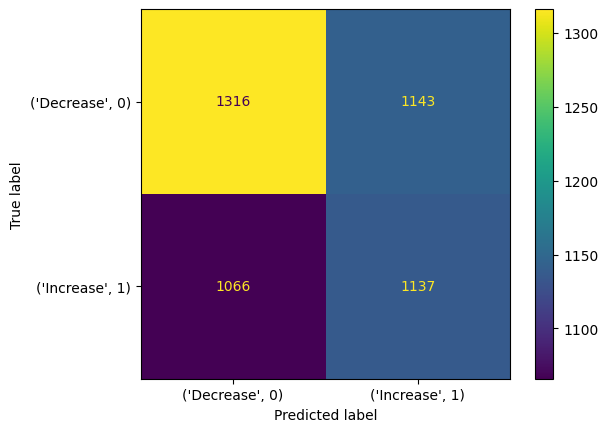

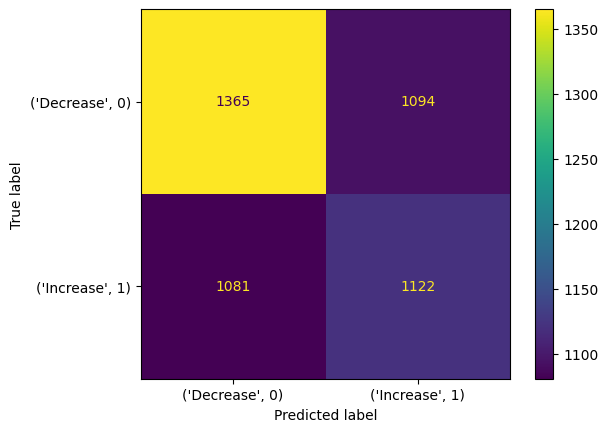

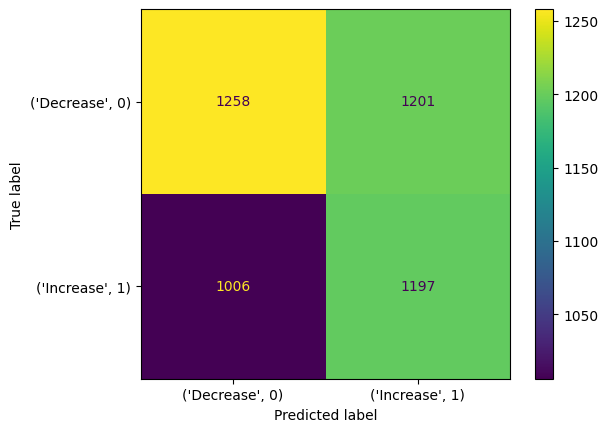

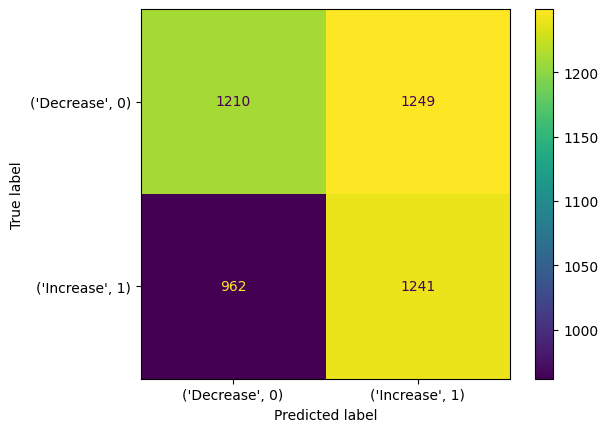

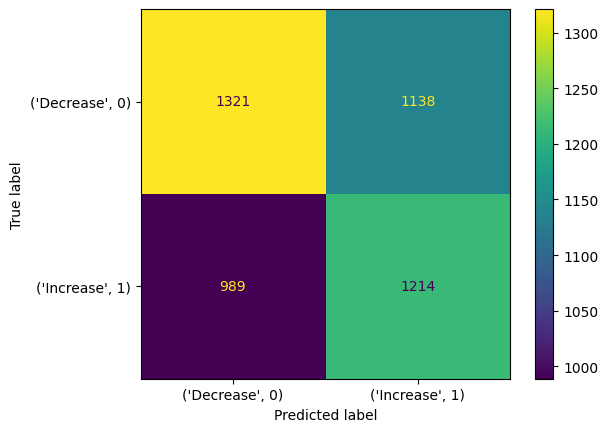

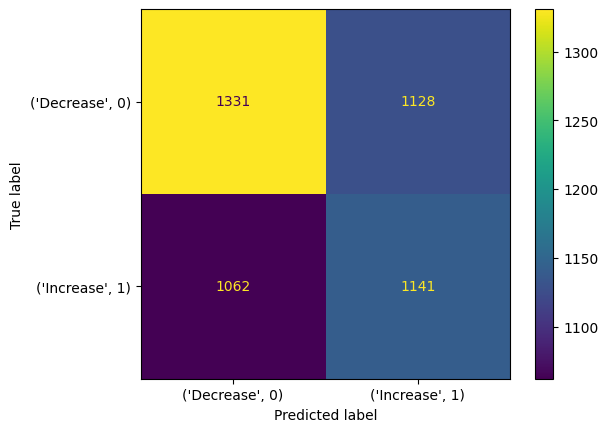

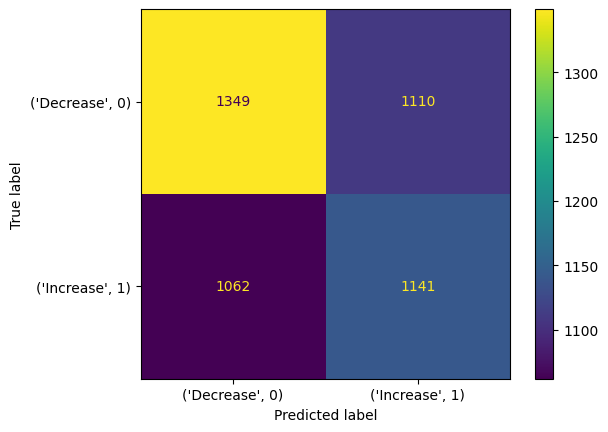

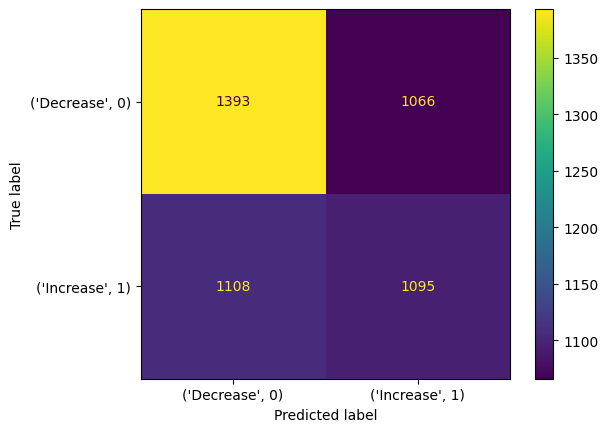

In [271]:
# first layer of for loop
for new_data in new_columns:
    # second layer of for loop
    for second_column in new_columns:
        # checking condition if previouse column and current column are same
        if new_data!=second_column:
            # storing first column and second column as list 
            temp_arr=[new_data,second_column]
            # sorting the list for validation 
            temp_arr.sort()
            temp_arr=temp_arr[0]+"-"+temp_arr[1]
            # validation for combinations of first and second columns
            if Results[(Results['Parameters']=='SVC') & (Results['Data']==temp_arr) ].empty:
                
                # adding both column data to baseline dataset
                tempdf= pd.concat([base_X_classification,data[[new_data,second_column]]],axis=1)
                # Training and testing model with 2 datapoints added 
                Baseline_SVC(tempdf,Y_classification,temp_arr,True)
                # print(temp_arr)


### Random Forest Classifier

,Parameters,Train Accuracy/MSE,Test Accuracy/R2,Precision/RMSE,Recall,f Measure,Data,Comment
25,Random Forest,1.0,0.562634,0.555163,0.549585,0.55236,Base Data-Base Randomforest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."


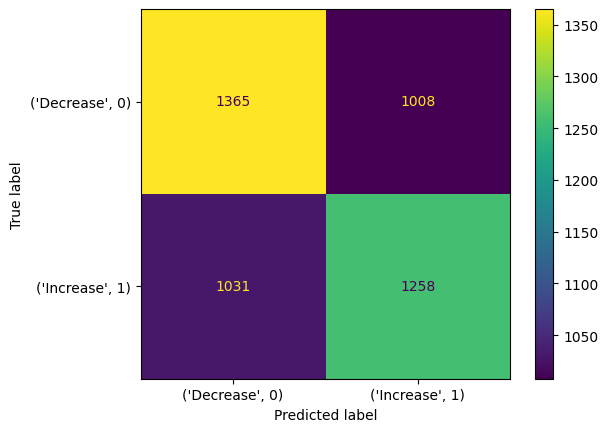

In [93]:
# Procedure encapsulating Baseline SVC model 
def Baseline_Randomforest(X,Y,Comment,HP):

    # test train split
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=19)

    # defining scaler
    scaler = StandardScaler()

    # changing the shape of train and test splits
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Standardizing the data using standard scaler
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    #  defining model 
    if HP==False:
        RFC= RandomForestClassifier(random_state=42)
        # print(" no HP")
    else:
        RFC= RandomForestClassifier(criterion= 'log_loss', n_estimators= 175,bootstrap= False,random_state=42)
    # fitting data to model
    RFC.fit(x_train, y_train)

    # predicting using unknown data 
    y_pred = RFC.predict(x_test)

    # classification_report_output = classification_report(y_test, y_pred)
    Test_accuracy=metrics.accuracy_score(y_test,y_pred) # Storing test data accuracy to a variable for result recording     
    training_accuracy=metrics.accuracy_score(y_train,RFC.predict(x_train))  # checking train accuracy
    Precision=metrics.precision_score(y_test,y_pred) # Calculating the test data predictions precision  
    Recall=metrics.recall_score(y_test,y_pred)  # Calculating the Recall for test data prediction
    f_measure= (2*Precision)*Recall/(Precision+Recall)

    disp = ConfusionMatrixDisplay(metrics.confusion_matrix(y_test,y_pred),display_labels=Y_labels)
    disp.plot()
    
    i=Results.shape[0]+1  

    # Storing output to Results dataframe
    Results.loc[i]=['Random Forest',training_accuracy,Test_accuracy,Precision,Recall,f_measure,Comment,RFC.get_params()]     # storing the results

    return RFC
# calling baseline model with baseline data
rf=Baseline_Randomforest(base_X_classification,Y_classification,"Base Data-Base Randomforest",False)
# showing results of baseline model with base data 
Results.tail(1)

In [112]:
rf

array([0.3014944 , 0.06350127, 0.0617206 , 0.05980413, 0.01650461,
       0.07229628, 0.03941657, 0.06002995, 0.3252322 ])

In [104]:
base_X_classification.columns.values

array(['Day', 'EBIDTA in millions', 'EPS', 'FEDFUNDS', 'GDP', 'Month',
       'Symbol_label', 'Unemployment Rate', 'Volume Lagged'], dtype=object)

In [119]:
imp=pd.DataFrame(rf.feature_importances_,base_X_classification.columns.values).reset_index()

In [122]:
imp.sort_values(0)

,index,0
4,GDP,0.016505
6,Symbol_label,0.039417
3,FEDFUNDS,0.059804
7,Unemployment Rate,0.060030
2,EPS,0.061721
1,EBIDTA in millions,0.063501
5,Month,0.072296
0,Day,0.301494
8,Volume Lagged,0.325232


,Parameters,Train Accuracy/MSE,Test Accuracy/R2,Precision/RMSE,Recall,f Measure,Data,Comment
17,Random Forest,1.00000,0.690262,0.684740,0.684142,0.684441,Oil-Volume Lagged,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
18,Random Forest,0.55534,0.552338,0.535667,0.544,0.539802,Base Data-Gridsearch model Random Forest,"{'criterion': 'log_loss', 'n_estimators': 175}"


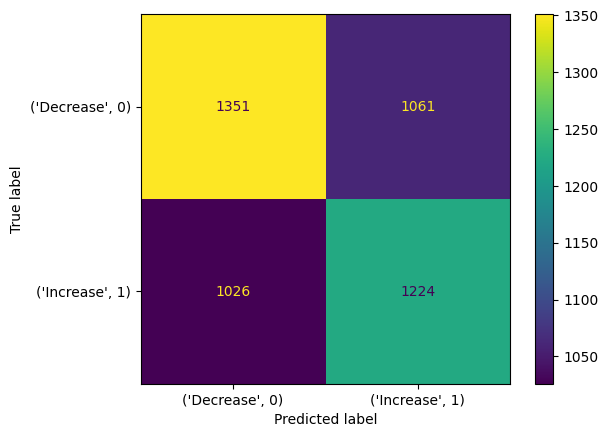

In [59]:
def HyperParam_Randomforest(X,Y,Comment):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    
    # defining scaler
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    #  changing the shape of train and test splits
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    #  defining model 
    RFC= RandomForestClassifier()

    max_iter_=range(10,20)
    # setting hyper parameters 
    hyperparamter=[{'n_estimators': [125,150,175,200],'criterion': ['gini', 'entropy', 'log_loss']}]

    # Applying hyper paramters to grid search
    Optimized_param_model_RF=GridSearchCV(RFC,param_grid=hyperparamter,scoring='accuracy',cv=5,return_train_score=True)  

    # training grid search model 
    Optimized_param_model_RF.fit(x_train, y_train)

    Best_combination=Optimized_param_model_RF.best_params_  # storing the best paramters into variable for results recording
    training_cv_score=Optimized_param_model_RF.best_score_  # storing train datas crosss validation score into a variable or results recording   
    y_pred=Optimized_param_model_RF.best_estimator_.predict(x_test)# using grid search model to predict the target of x_test (test features)

    Test_accuracy=metrics.accuracy_score(y_test,y_pred) # Storing test data accuracy to a variable for result recording     
    Precision=metrics.precision_score(y_test,y_pred) # Calculating the test data predictions precision  
    Recall=metrics.recall_score(y_test,y_pred)  # Calculating the Recall for test data prediction
    f_measure= (2*Precision)*Recall/(Precision+Recall)

    disp = ConfusionMatrixDisplay(metrics.confusion_matrix(y_test,y_pred),display_labels=Y_labels)
    disp.plot()
    i=Results.shape[0]+1  

    Results.loc[i]=['Random Forest',training_cv_score,Test_accuracy,Precision,Recall,f_measure,Comment,Best_combination]     # storing the results
    # return Optimized_param_model_RF
HyperParam_Randomforest(base_X_classification,Y_classification,"Base Data-Gridsearch model Random Forest")
Results.tail(2)

In [274]:
Results.tail(1)['Comment']

19    {'criterion': 'log_loss', 'n_estimators': 175}
Name: Comment, dtype: object

In [57]:
Results.tail(1)['Comment'].values

array([{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 175, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}],
      dtype=object)

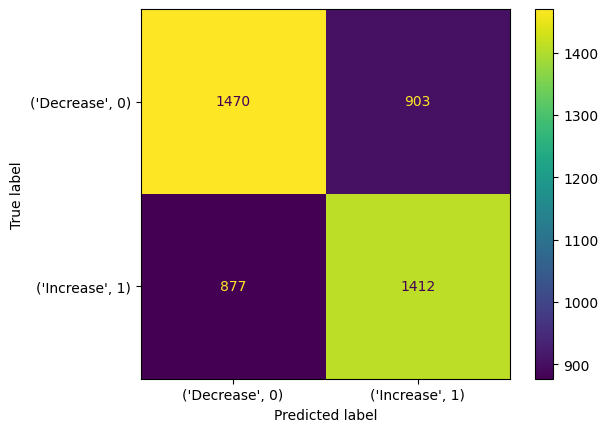

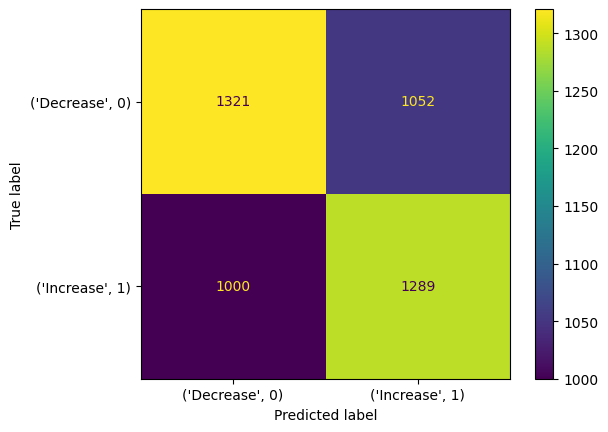

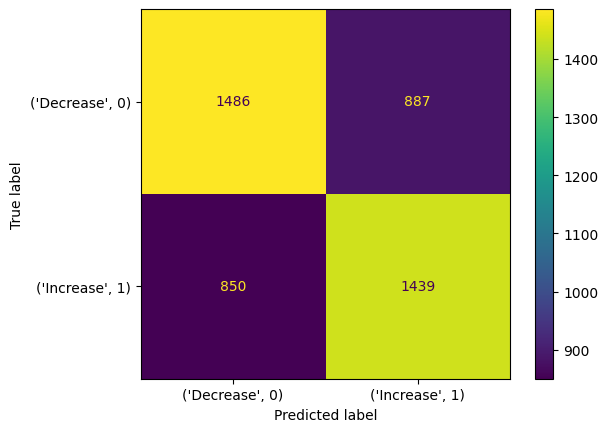

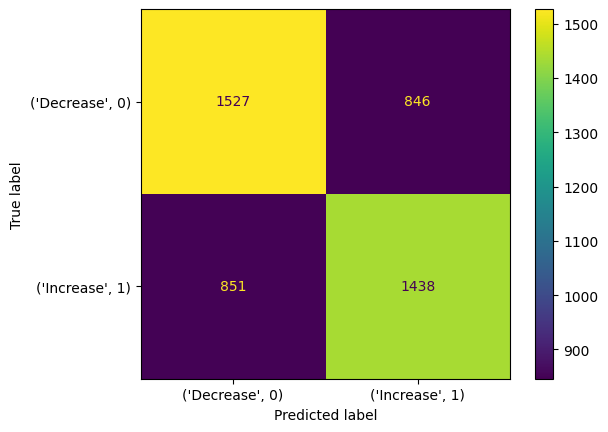

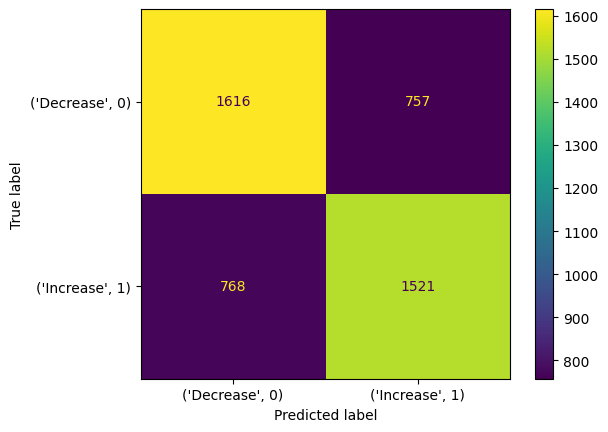

In [42]:
# using for loop to add each columns impact on prediction (individual columns only)
for new_data in new_columns:
    # adding column data to the baseline lineset
    tempdf= pd.concat([base_X_classification,data[[new_data]]],axis=1)
    # testing model performance with newly added data
    Baseline_Randomforest(tempdf,Y_classification,new_data,True)

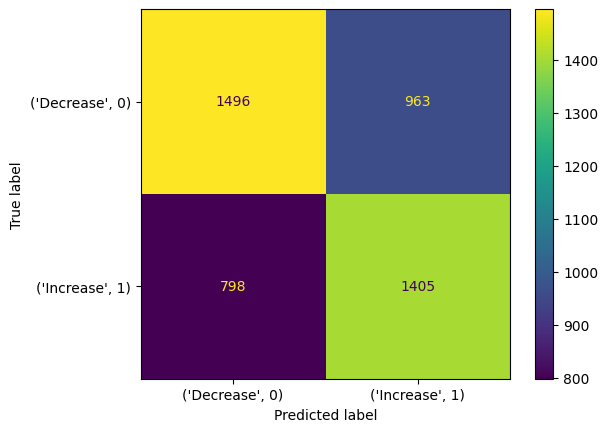

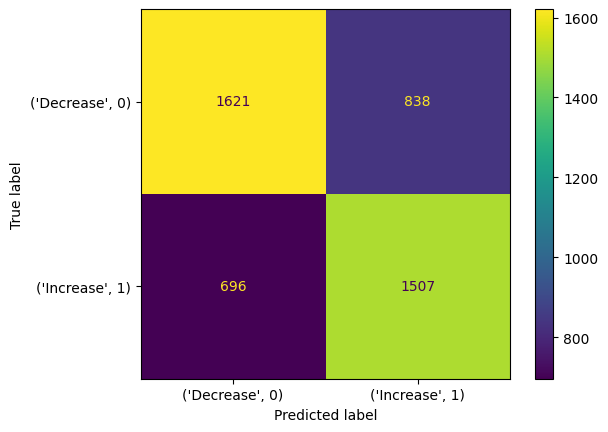

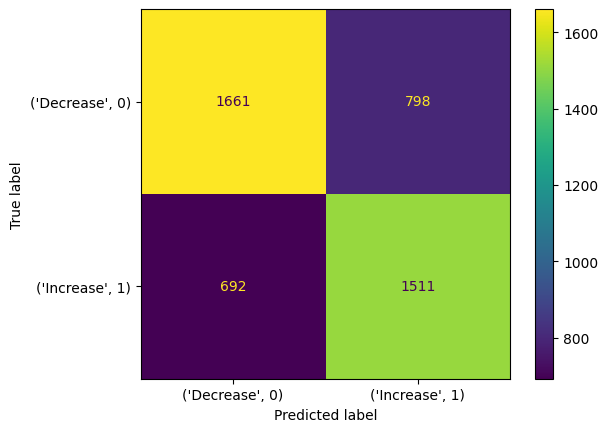

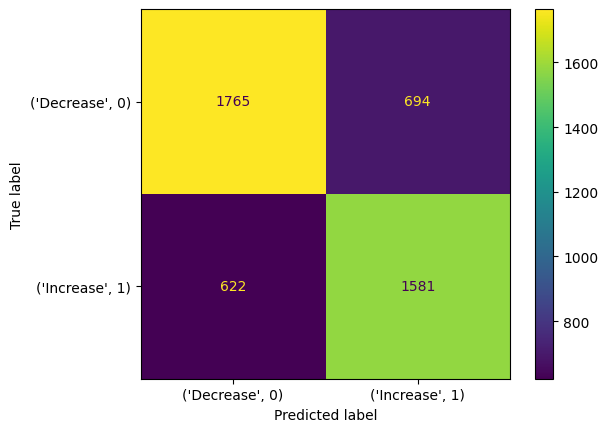

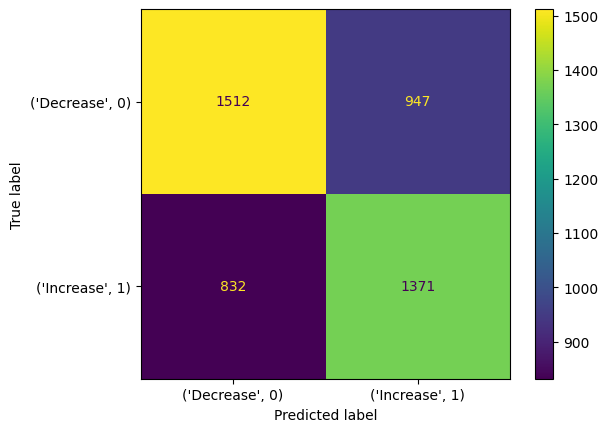

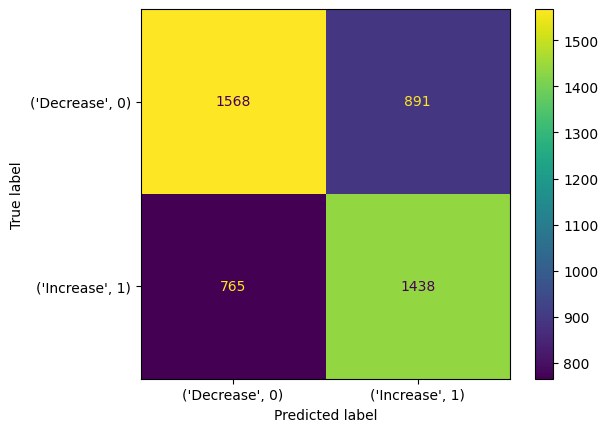

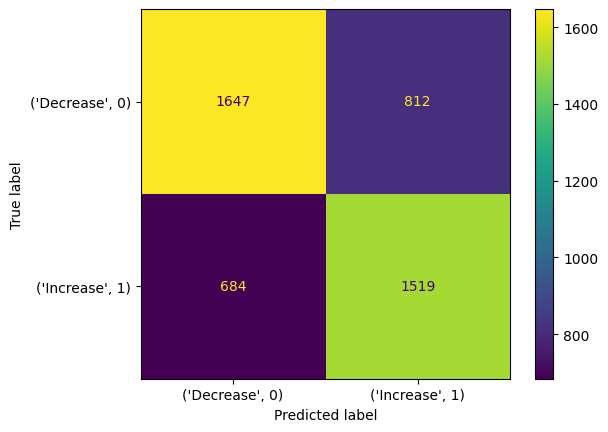

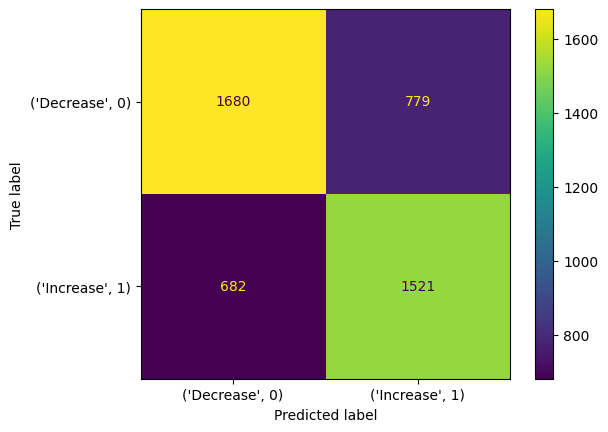

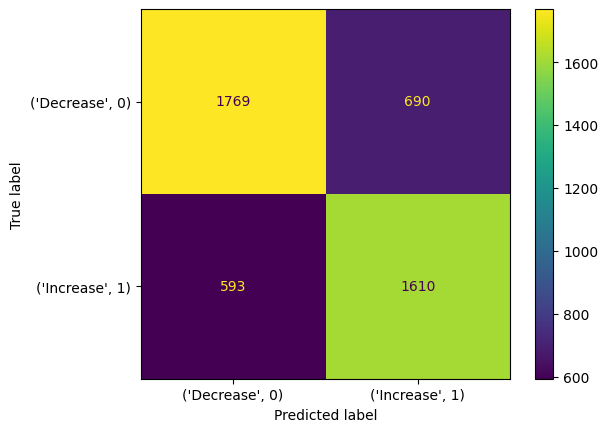

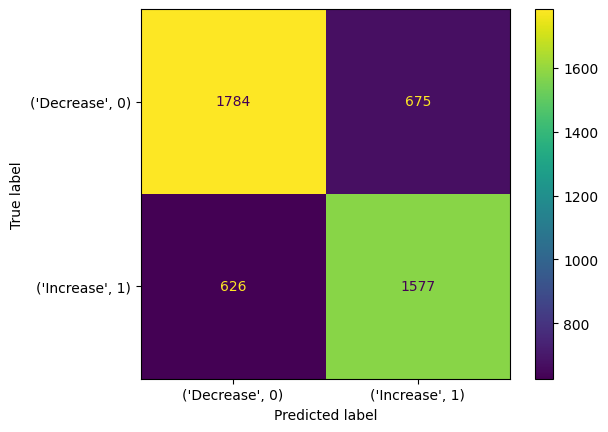

In [278]:
# first layer of for loop
for new_data in new_columns:
    # second layer of for loop
    for second_column in new_columns:
        # checking condition if previouse column and current column are same
        if new_data!=second_column:
            # storing first column and second column as list 
            temp_arr=[new_data,second_column]
            # sorting the list for validation 
            temp_arr.sort()
            temp_arr=temp_arr[0]+"-"+temp_arr[1]
            # validation for combinations of first and second columns
            if Results[(Results['Parameters']=='Random Forest') & (Results['Data']==temp_arr) ].empty:
                
                # adding both column data to baseline dataset
                tempdf= pd.concat([base_X_classification,data[[new_data,second_column]]],axis=1)
                # Training and testing model with 2 datapoints added 
                Baseline_Randomforest(tempdf,Y_classification,temp_arr,True)

In [279]:
Results[Results['Data']==temp_arr]

,Parameters,Train Accuracy/MSE,Test Accuracy/R2,Precision/RMSE,Recall,f Measure,Data,Comment
17,SVC,0.584482,0.533677,0.506710,0.497049,0.501833,Oil-Open-Oil-Volume Lagged,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
34,Random Forest,1.000000,0.720935,0.700266,0.715842,0.707969,Oil-Open-Oil-Volume Lagged,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."


In [280]:
Results[(Results['Parameters']=='SVM') & (Results['Data']==temp_arr) ]

,Parameters,Train Accuracy/MSE,Test Accuracy/R2,Precision/RMSE,Recall,f Measure,Data,Comment


## Regression

### SVR

In [4]:
Y_regression=data[['Close/Last']]
base_X_regression=data[data.columns.difference(['Close/Last','Close Label','YC Ratio Wallstreet','Steel Production','YC Ratio arturo','Date','Year','Oil-Open','Oil-Volume Lagged'])]


In [282]:
base_X_regression.head()

,Day,EBIDTA in millions,EPS,FEDFUNDS,GDP,Month,Symbol_label,Unemployment Rate,Volume Lagged
0,3,918,0.56,0.07,17550.68,1,0,6.6,3475200
1,3,3196,1.25,0.07,17550.68,1,5,6.6,4958126
2,3,1641,0.90,0.07,17550.68,1,3,6.6,7414405
3,3,8768,0.98,0.07,17550.68,1,6,6.6,997018
4,3,11833,2.57,0.07,17550.68,1,2,6.6,4540272


In [283]:
def Baseline_SCR(X,Y,Comment,HP):
    scaler = StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if HP==False:
        Baseline_svr_model = SVR()
    else:
        Baseline_svr_model = SVR(C = 3.0,cache_size = 200,coef0 = 0.0,degree = 3,epsilon = 0.1,gamma = 'scale',kernel = 'rbf',max_iter = -1,shrinking = True,
        tol = 0.001,verbose = False)
        
    Baseline_svr_model.fit(X_train_scaled,y_train)

    # Make predictions on the test set
    y_pred = Baseline_svr_model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred,squared=True)
    print(f'Mean Squared Error: {mse}')

    rmse = mean_squared_error(y_test, y_pred,squared=False)
    print(f'Root Mean Squared Error: {rmse}')

    r2 = r2_score(y_test, y_pred)
    print(f'r2: {r2}')
    
    i=Results.shape[0]+1  

    Results.loc[i]=['SVR',mse,r2,rmse,'','',Comment,Baseline_svr_model.get_params()]     # storing the results

    return y_test, y_pred

Baseline_SCR(base_X_regression,Y_regression,"Base Data - Baseline SVR",False)

f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 243.2331709312965
Root Mean Squared Error: 15.595934435977105
r2: 0.6723512163357876


(       Close/Last
 14903       13.09
 6800        52.85
 5787        51.75
 1323        99.03
 4038        89.33
 ...           ...
 5524        48.63
 6679        78.38
 1811        71.00
 8371        63.60
 9149       125.11
 
 [4662 rows x 1 columns],
 array([14.71836236, 53.23583381, 42.2826498 , ..., 64.81268843,
        53.91346836, 74.56255846]))

In [284]:

# y,p=Baseline_SCR(base_X_regression,Y_regression,"Base Data - Baseline SVR",False)
# y.reset_index(drop=True,inplace=True)
# p=pd.DataFrame(p)

# plt.figure(figsize=(20, 5))
# plt.plot(y[100:150],label='Actual')
# plt.plot(p[100:150],label='Prediction')
# # Add labels and title
# plt.xlabel('X-axis Label')
# plt.ylabel('Y-axis Label')
# plt.title('Baseline SVR Actual vs Prediction')
# plt.legend()
# # Show the plot
# plt.show()

f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 193.53878688978827
Root Mean Squared Error: 13.911821839349017
r2: 0.7392923511481175


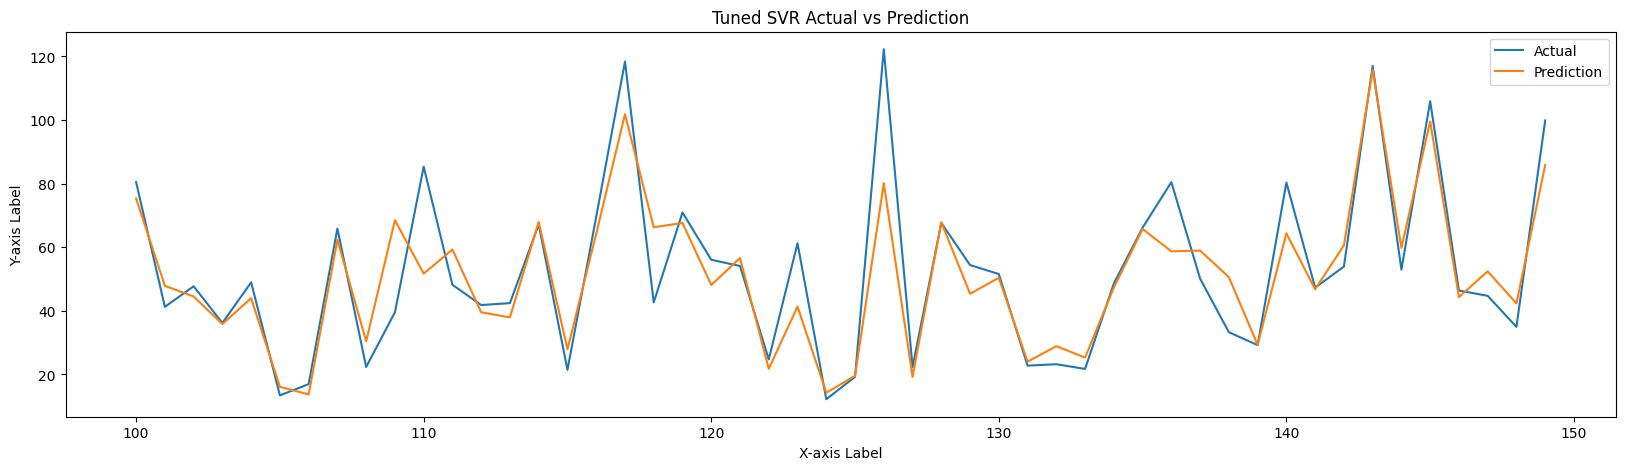

In [285]:
y,p=Baseline_SCR(base_X_regression,Y_regression,"Base Data - Baseline SVR",True)
y.reset_index(drop=True,inplace=True)

p=pd.DataFrame(p)
plt.figure(figsize=(20, 5))
plt.plot(y[100:150],label='Actual')
plt.plot(p[100:150],label='Prediction')
# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Tuned SVR Actual vs Prediction')
plt.legend()
# Show the plot
plt.show()

In [286]:
def GS_SVR(X,Y,Comment):

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(x_train)
    X_test_scaled = scaler.transform(x_test)

    svr_model = SVR()

    hyperparamter=[{'C': [1,2,3],
    'cache_size': [200],
    'coef0': [0.0],
    'degree': [3],
    'epsilon': [0.1],
    'gamma': ['scale'],
    'kernel': ['rbf','linear'],
    'max_iter': [-1],
    'shrinking': [True],
    'tol': [0.001],
    'verbose': [False]}] 
    Optimized_param_model_SVR=GridSearchCV(svr_model,param_grid=hyperparamter,scoring='r2' ,cv=5,return_train_score=True)  

    Optimized_param_model_SVR.fit(X_train_scaled, y_train)

    Best_combination=Optimized_param_model_SVR.best_params_  # storing the best paramters into variable for results recording
    y_pred=Optimized_param_model_SVR.best_estimator_.predict(X_test_scaled)# using grid search model to predict the target of x_test (test features)

    mse = mean_squared_error(y_test, y_pred,squared=True)
    print(f'Mean Squared Error: {mse}')

    rmse = mean_squared_error(y_test, y_pred,squared=False)
    print(f'Root Mean Squared Error: {mse}')

    r2 = r2_score(y_test, y_pred)
    print(f'r2: {r2}')

    i=Results.shape[0]+1  

    Results.loc[i]=['SVR',mse,r2,rmse,'','',Comment,Best_combination]     # storing the results

    # cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
    # disp = ConfusionMatrixDisplay(metrics.confusion_matrix(y_test,y_pred),display_labels=Y_labels)
    # disp.plot()
    # plt.show()

    # Results

GS_SVR(base_X_regression,Y_regression,'Base Data - Gridsearch SVR')

f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
f:\One Drive-reyal.net\OneDrive - 

Mean Squared Error: 193.53878688978827
Root Mean Squared Error: 193.53878688978827
r2: 0.7392923511481175


In [287]:
SVC_final_HP=Results[Results['Data']=='Base Data - Gridsearch SVR']['Comment'].values[0]
str(SVC_final_HP).replace("'",'').replace("{",'').replace("}",'').replace(":",'=')

'C= 3, cache_size= 200, coef0= 0.0, degree= 3, epsilon= 0.1, gamma= scale, kernel= rbf, max_iter= -1, shrinking= True, tol= 0.001, verbose= False'

In [288]:
# using for loop to add each columns impact on prediction (individual columns only)
for new_data in new_columns:
    # adding column data to the baseline lineset
    tempdf= pd.concat([base_X_regression,data[[new_data]]],axis=1)
    # testing model performance with newly added data
    Baseline_SCR(tempdf,Y_regression,new_data,True)

f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 194.90770305261245
Root Mean Squared Error: 13.960934891783303
r2: 0.737448343959582


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 188.2558901212801
Root Mean Squared Error: 13.72063738028522
r2: 0.7464087107046611


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 186.5005669115518
Root Mean Squared Error: 13.656521039838507
r2: 0.7487732299534253


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 184.27148076490704
Root Mean Squared Error: 13.574663191582584
r2: 0.7517759345674158


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 205.68447580867343
Root Mean Squared Error: 14.341704076178445
r2: 0.7229314239530324


In [289]:
# first layer of for loop
for new_data in new_columns:
    # second layer of for loop
    for second_column in new_columns:
        # checking condition if previouse column and current column are same
        if new_data!=second_column:
            # storing first column and second column as list 
            temp_arr=[new_data,second_column]
            # sorting the list for validation 
            temp_arr.sort()
            temp_arr=temp_arr[0]+"-"+temp_arr[1]
            # validation for combinations of first and second columns
            if Results[(Results['Parameters']=='SVR') & (Results['Data']==temp_arr) ].empty:
                # adding both column data to baseline dataset
                tempdf= pd.concat([base_X_regression,data[[new_data,second_column]]],axis=1)
                # Training and testing model with 2 datapoints added 
                Baseline_SCR(tempdf,Y_regression,temp_arr,True)

f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 191.86036099281594
Root Mean Squared Error: 13.851366755407783
r2: 0.7415532853846277


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 187.79575341338142
Root Mean Squared Error: 13.703859070108004
r2: 0.7470285407717732


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 187.15318126551446
Root Mean Squared Error: 13.680394046426969
r2: 0.7478941216539325


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 205.3855986044773
Root Mean Squared Error: 14.331280424458846
r2: 0.7233340283841834


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 188.44025158064537
Root Mean Squared Error: 13.727354136199931
r2: 0.7461603654329849


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 188.53215537318982
Root Mean Squared Error: 13.730701197433065
r2: 0.746036565847073


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 201.41690408917864
Root Mean Squared Error: 14.192142336137227
r2: 0.7286800834707231


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 183.9528700126188
Root Mean Squared Error: 13.562922620608687
r2: 0.7522051211995263


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 197.71047460647367
Root Mean Squared Error: 14.060955678988313
r2: 0.7336728527837888


f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 194.9481923521507
Root Mean Squared Error: 13.962384909181909
r2: 0.7373938025921594


In [290]:
Results[(Results['Parameters']=='SVM') & (Results['Data']==temp_arr) ]

,Parameters,Train Accuracy/MSE,Test Accuracy/R2,Precision/RMSE,Recall,f Measure,Data,Comment


## LSTM


In [5]:
Y_regression=data[['Close/Last']]
base_X_regression=data[data.columns.difference(['Close/Last','Close Label','YC Ratio Wallstreet','Steel Production','YC Ratio arturo','Date','Year','Volume'])]

x_train, x_test, y_train, y_test = train_test_split(base_X_regression, Y_regression, test_size=0.3, random_state=42)

In [88]:
def Base_LSTM(base_X_regression_LSTM,Y_regression_LSTM,Comment,HP):
    
    Y_regression_LSTM=Y_regression_LSTM.to_numpy().reshape(-1,1)
    base_X_regression_LSTM=base_X_regression_LSTM.to_numpy()

    Min_max_scale = MinMaxScaler(feature_range=(0, 1))
    scaler = StandardScaler()

    base_X_regression_normalize = Min_max_scale.fit_transform(base_X_regression_LSTM)
    # base_X_regression_normalize = scaler.fit_transform(base_X_regression)
    base_X_regression_normalize= base_X_regression_normalize.reshape(base_X_regression_normalize.shape[0],1,base_X_regression_normalize.shape[1])

    x_train, x_test, y_train, y_test = train_test_split(base_X_regression_normalize, Y_regression_LSTM, test_size=0.3, random_state=42)

    # Build the LSTM model

    if HP==False:
        model = Sequential()   
        model.add(LSTM(50, input_shape=(1, x_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    else:
        model = Sequential()   
        model.add(LSTM(50, input_shape=(1, x_train.shape[2]), activation='tanh'))
        model.add(Dense(1))
        model.compile(optimizer='sgd', loss='mean_squared_error')
        
    # model = Sequential()   
    # model.add(LSTM(50, input_shape=(1, x_train.shape[2]), activation='tanh'))
    # model.add(Dense(1))
    # model.compile(optimizer='sgd', loss='mean_squared_error')

    model.fit(x_train, y_train, epochs=50, batch_size=32)
    predictions = model.predict(x_test)

    mse = mean_squared_error(y_test,predictions)
    
    rmse = mean_squared_error(y_test, predictions,squared=False)
    print(f'Root Mean Squared Error: {rmse}')

    r2 = r2_score(y_test, predictions)
    print(f"Mean Squared Error: {mse}")
    print(f"R2: {r2}")

    i=Results.shape[0]+1  
    Results.loc[i]=['LSTM',mse,r2,rmse,'','',Comment,'Base LSTM']     # storing the results

    return y_test, predictions

y,p=Base_LSTM(base_X_regression,Y_regression,"Base LSTM - Base Dataset",False)

Epoch 1/50
340/340 [==============================] - 3s 3ms/step - loss: 3128.3777
Epoch 2/50
340/340 [==============================] - 1s 3ms/step - loss: 1607.2173
Epoch 3/50
340/340 [==============================] - 1s 3ms/step - loss: 1049.1227
Epoch 4/50
340/340 [==============================] - 1s 3ms/step - loss: 839.7513
Epoch 5/50
340/340 [==============================] - 1s 3ms/step - loss: 770.5768
Epoch 6/50
340/340 [==============================] - 1s 3ms/step - loss: 751.4618
Epoch 7/50
340/340 [==============================] - 1s 3ms/step - loss: 745.4385
Epoch 8/50
340/340 [==============================] - 1s 2ms/step - loss: 738.5322
Epoch 9/50
340/340 [==============================] - 1s 2ms/step - loss: 679.4415
Epoch 10/50
340/340 [==============================] - 1s 2ms/step - loss: 577.4644
Epoch 11/50
340/340 [==============================] - 1s 2ms/step - loss: 503.3625
Epoch 12/50
340/340 [==============================] - 1s 3ms/step - loss: 466.381

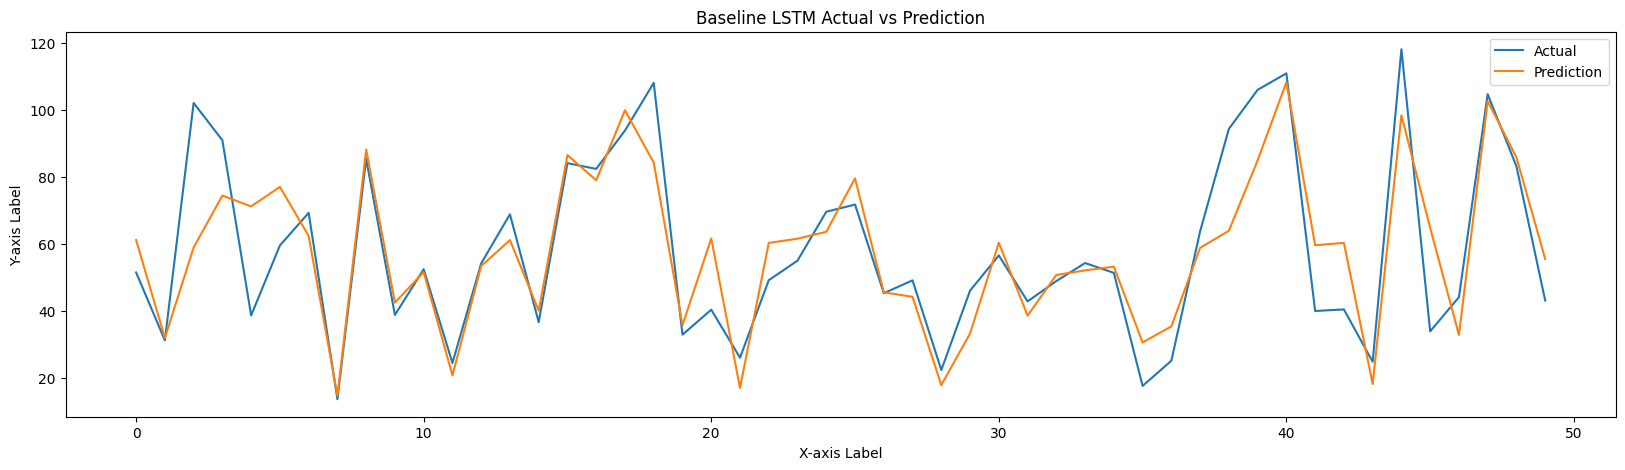

In [89]:
plt.figure(figsize=(20, 5))
plt.plot(y[100:150],label='Actual')
plt.plot(p[100:150],label='Prediction')
# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Baseline LSTM Actual vs Prediction')
plt.legend()
# Show the plot
plt.show()

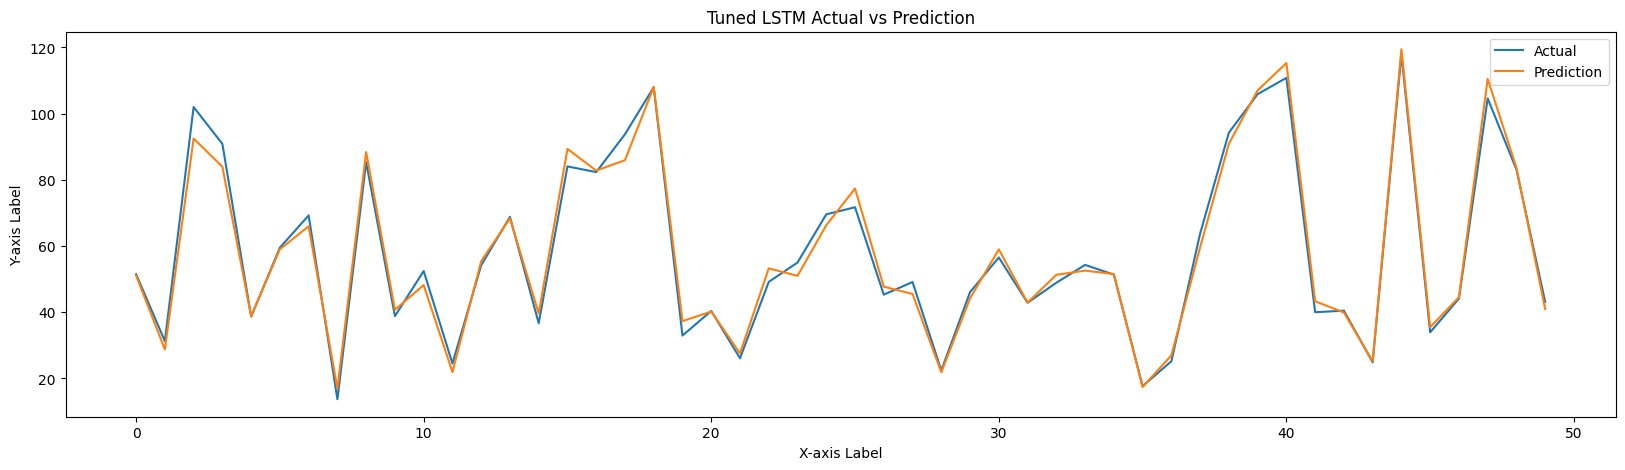

In [38]:
y,p=Base_LSTM(base_X_regression,Y_regression,"Tunned LSTM - Graph",True)
# y.reset_index(drop=True,inplace=True)
# p=pd.DataFrame(p)
plt.figure(figsize=(20, 5))
plt.plot(y[100:150],label='Actual')
plt.plot(p[100:150],label='Prediction')
# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Tuned LSTM Actual vs Prediction')
plt.legend()
# Show the plot
plt.show()

In [293]:
def GS_LSTM(X_ANN,Y_ANN, Comment):
    
    x_train, x_test, y_train, y_test = train_test_split(X_ANN, Y_ANN, test_size=0.3, random_state=42)
    scaler = StandardScaler()

    #  changing the shape of train and test splits
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    def build_ann_model(activation='relu', optimizer='adam'):
     # Build the LSTM model
        model = Sequential()
        model.add(LSTM(50, input_shape=(1, x_train.shape[1])))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    # Create a pipeline with preprocessing and the ANN model
    pipeline = Pipeline([
      
        ('ann', KerasRegressor(build_fn=build_ann_model, verbose=0, activation='relu',epochs=50))  # Specify activation here
    ])

    # Define hyperparameters and their possible values for the grid search
    param_grid = {
        'ann__activation': ['relu', 'tanh'],  # Activation function
        'ann__optimizer': ['adam', 'sgd']  # Optimizer
    }

    # Create a GridSearchCV object with cross-validation
    grid_search = GridSearchCV(
        estimator=pipeline, param_grid=param_grid, scoring='explained_variance',  # Evaluation metric
        cv=5
    )
    x_train_reshaped = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test_reshaped = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    # Fit the grid search to your training data
    grid_search.fit(x_train_reshaped, y_train)
    y_pred = grid_search.predict(x_test_reshaped)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    print(f'Mean Squared Error: {mse}')

    r2 = r2_score(y_test, y_pred)
    i=Results.shape[0]+1  
    Results.loc[i]=['LSTM',mse,r2,rmse,'','',Comment,'']     # storing the results

    # return grid_search.best_estimator_
GS_LSTM(base_X_regression,Y_regression,"LSTM - Base Dataset")

f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\scikeras\w

Mean Squared Error: 21.777773481435684


In [294]:
# using for loop to add each columns impact on prediction (individual columns only)
for new_data in new_columns:
    # adding column data to the baseline lineset
    tempdf= pd.concat([base_X_regression,data[[new_data]]],axis=1)
    # testing model performance with newly added data
    Base_LSTM(tempdf,Y_regression,new_data,True)

Epoch 1/50
340/340 [==============================] - 5s 1ms/step - loss: 562.9115
Epoch 2/50
340/340 [==============================] - 0s 1ms/step - loss: 336.5898
Epoch 3/50
340/340 [==============================] - 0s 1ms/step - loss: 259.8601
Epoch 4/50
340/340 [==============================] - 0s 1ms/step - loss: 199.5145
Epoch 5/50
340/340 [==============================] - 0s 1ms/step - loss: 194.9660
Epoch 6/50
340/340 [==============================] - 0s 1ms/step - loss: 152.6706
Epoch 7/50
340/340 [==============================] - 0s 1ms/step - loss: 121.0788
Epoch 8/50
340/340 [==============================] - 0s 1ms/step - loss: 112.3941
Epoch 9/50
340/340 [==============================] - 0s 1ms/step - loss: 82.3004
Epoch 10/50
340/340 [==============================] - 0s 1ms/step - loss: 76.0594
Epoch 11/50
340/340 [==============================] - 0s 1ms/step - loss: 55.3824
Epoch 12/50
340/340 [==============================] - 0s 1ms/step - loss: 49.6314
Epoch

In [295]:
# first layer of for loop
for new_data in new_columns:
    # second layer of for loop
    for second_column in new_columns:
        # checking condition if previouse column and current column are same
        if new_data!=second_column:
            # storing first column and second column as list 
            temp_arr=[new_data,second_column]
            # sorting the list for validation 
            temp_arr.sort()
            temp_arr=temp_arr[0]+"-"+temp_arr[1]
            # validation for combinations of first and second columns
            if Results[(Results['Parameters']=='LSTM') & (Results['Data']==temp_arr) ].empty:
                # adding both column data to baseline dataset
                tempdf= pd.concat([base_X_regression,data[[new_data,second_column]]],axis=1)
                # Training and testing model with 2 datapoints added 
                Base_LSTM(tempdf,Y_regression,temp_arr,True)

Epoch 1/50
340/340 [==============================] - 2s 1ms/step - loss: 570.9192
Epoch 2/50
340/340 [==============================] - 0s 1ms/step - loss: 348.7778
Epoch 3/50
340/340 [==============================] - 0s 1ms/step - loss: 265.0636
Epoch 4/50
340/340 [==============================] - 0s 1ms/step - loss: 195.1164
Epoch 5/50
340/340 [==============================] - 0s 1ms/step - loss: 155.6510
Epoch 6/50
340/340 [==============================] - 0s 1ms/step - loss: 116.8303
Epoch 7/50
340/340 [==============================] - 0s 1ms/step - loss: 89.1376
Epoch 8/50
340/340 [==============================] - 0s 1ms/step - loss: 70.6011
Epoch 9/50
340/340 [==============================] - 0s 1ms/step - loss: 60.4600
Epoch 10/50
340/340 [==============================] - 0s 1ms/step - loss: 53.4063
Epoch 11/50
340/340 [==============================] - 0s 1ms/step - loss: 46.6331
Epoch 12/50
340/340 [==============================] - 0s 1ms/step - loss: 41.3230
Epoch 1

In [296]:
# plt.figure(figsize=(25, 10))
# plt.plot(y_test[1000:1150],label='Actual')
# plt.plot(predictions[1000:1150],label='Prediction')
# # Add labels and title
# plt.xlabel('X-axis Label')
# plt.ylabel('Y-axis Label')
# plt.title('Line Chart from NumPy Array')
# plt.legend()
# # Show the plot
# plt.show()

### ANN


In [297]:
def ANN_base(X_ANN,Y_ANN, Comment,HP):

    # Set random seed for NumPy for reproducibility
    np.random.seed(42)

    # Set random seed for TensorFlow/Keras for reproducibility
    tf.random.set_seed(42)
    x_train, x_test, y_train, y_test = train_test_split(X_ANN, Y_ANN, test_size=0.3)
    scaler = StandardScaler()

    #  changing the shape of train and test spl its
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Train the model
    if HP==False:
        model = Sequential()
        model.add(Dense(32, activation='relu', input_dim=x_train.shape[1]))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1, activation='linear'))  # Assuming regression task
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=2)
    else:
        model = Sequential()
        model.add(Dense(32, activation='tanh', input_dim=x_train.shape[1]))
        model.add(Dense(16, activation='tanh'))
        model.add(Dense(1, activation='linear'))  # Assuming regression task
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))
        
    # Make predictions on the test set
    y_pred = model.predict(x_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    rmse = mean_squared_error(y_test, y_pred,squared=False)
    print(f'Root Mean Squared Error: {rmse}')
    r2 = r2_score(y_test, y_pred)
    
    i=Results.shape[0]+1  
    Results.loc[i]=['ANN',mse,r2,rmse,'','',Comment,'Base ANN']     # storing the results
    print(f'r2: {r2}')
    return y_test,y_pred

ANN_base(base_X_regression,Y_regression,"Base ANN - Base Dataset",False)

Epoch 1/50
340/340 - 1s - loss: 2362.5759 - val_loss: 593.5478 - 902ms/epoch - 3ms/step
Epoch 2/50
340/340 - 0s - loss: 524.0998 - val_loss: 457.6225 - 387ms/epoch - 1ms/step
Epoch 3/50
340/340 - 0s - loss: 449.4820 - val_loss: 413.6333 - 382ms/epoch - 1ms/step
Epoch 4/50
340/340 - 0s - loss: 416.3148 - val_loss: 387.6072 - 381ms/epoch - 1ms/step
Epoch 5/50
340/340 - 0s - loss: 393.8730 - val_loss: 368.5320 - 384ms/epoch - 1ms/step
Epoch 6/50
340/340 - 0s - loss: 375.7134 - val_loss: 352.0515 - 379ms/epoch - 1ms/step
Epoch 7/50
340/340 - 0s - loss: 357.3111 - val_loss: 336.5648 - 376ms/epoch - 1ms/step
Epoch 8/50
340/340 - 0s - loss: 338.7216 - val_loss: 316.6409 - 380ms/epoch - 1ms/step
Epoch 9/50
340/340 - 0s - loss: 316.8823 - val_loss: 295.7881 - 373ms/epoch - 1ms/step
Epoch 10/50
340/340 - 0s - loss: 291.2228 - val_loss: 271.1813 - 381ms/epoch - 1ms/step
Epoch 11/50
340/340 - 0s - loss: 264.2063 - val_loss: 245.9295 - 384ms/epoch - 1ms/step
Epoch 12/50
340/340 - 0s - loss: 242.255

(       Close/Last
 14903       13.09
 6800        52.85
 5787        51.75
 1323        99.03
 4038        89.33
 ...           ...
 5524        48.63
 6679        78.38
 1811        71.00
 8371        63.60
 9149       125.11
 
 [4662 rows x 1 columns],
 array([[ 13.709227],
        [ 58.711395],
        [ 57.80681 ],
        ...,
        [ 66.51233 ],
        [ 60.468586],
        [123.874405]], dtype=float32))

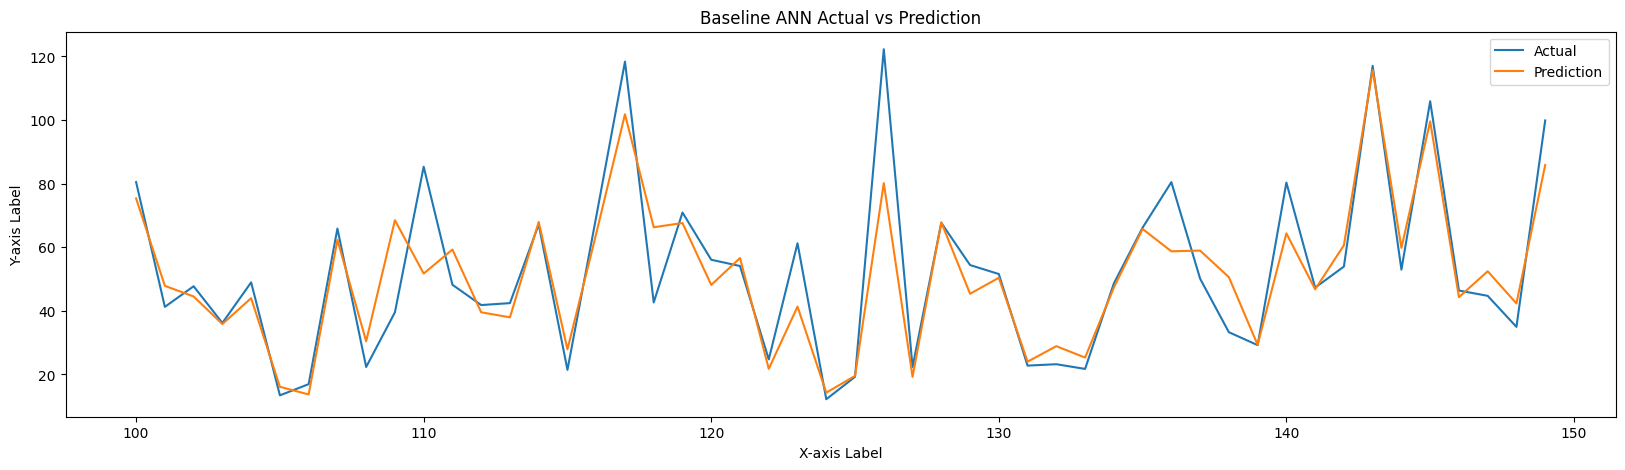

In [298]:

y.reset_index(drop=True,inplace=True)
p=pd.DataFrame(p)

plt.figure(figsize=(20, 5))
plt.plot(y[100:150],label='Actual')
plt.plot(p[100:150],label='Prediction')
# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Baseline ANN Actual vs Prediction')
plt.legend()
# Show the plot
plt.show()

f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
f:\One Drive-reyal.net\OneDrive - reyal\Data Science Class Material\4090\4090env\lib\site-packages\scikeras\w

Mean Squared Error: 13.562497257989223


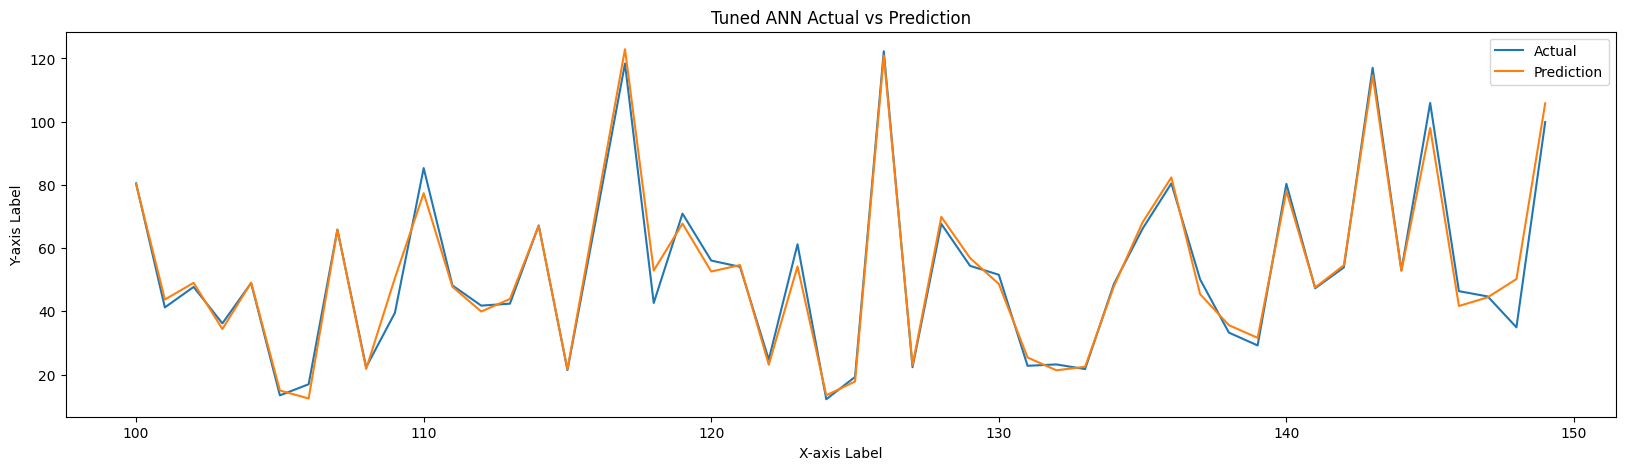

In [299]:
def GS_ANN(X_ANN,Y_ANN, Comment):
    
    x_train, x_test, y_train, y_test = train_test_split(X_ANN, Y_ANN, test_size=0.3, random_state=42)
    scaler = StandardScaler()

    #  changing the shape of train and test splits
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    def build_ann_model(activation='relu', optimizer='adam'):
        model = Sequential()

        model.add(Dense(32, activation=activation, input_dim=x_train.shape[1]))
        model.add(Dense(16, activation=activation))
        model.add(Dense(1, activation='linear'))  # Assuming regression task

        # Add output layer
        model.add(Dense(units=1))  # Output layer with linear (identity) activation for regression
        # Compile the model
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001)) 

        return model

    # Create a pipeline with preprocessing and the ANN model
    pipeline = Pipeline([
      
        ('ann', KerasRegressor(build_fn=build_ann_model, verbose=0, activation='relu',epochs=50))  # Specify activation here
    ])

    # Define hyperparameters and their possible values for the grid search
    param_grid = {
        'ann__activation': ['relu', 'tanh'],  # Activation function
        'ann__optimizer': ['adam', 'sgd']  # Optimizer
    }

    # Create a GridSearchCV object with cross-validation
    grid_search = GridSearchCV(
        estimator=pipeline, param_grid=param_grid, scoring='explained_variance',  # Evaluation metric
        cv=5
    )

    # Fit the grid search to your training data
    grid_search.fit(x_train, y_train)

    
    y_pred = grid_search.predict(x_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    print(f'Mean Squared Error: {mse}')

    r2 = r2_score(y_test, y_pred)
    i=Results.shape[0]+1  
    Results.loc[i]=['ANN',mse,r2,rmse,'','',Comment,'']     # storing the results

    return y_test, y_pred,grid_search
y,p,GS=GS_ANN(base_X_regression,Y_regression,"GS ANN - Base Dataset")

y.reset_index(drop=True,inplace=True)
p=pd.DataFrame(p)

plt.figure(figsize=(20, 5))
plt.plot(y[100:150],label='Actual')
plt.plot(p[100:150],label='Prediction')
# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Tuned ANN Actual vs Prediction')
plt.legend()
# Show the plot
plt.show()

In [300]:
Results

,Parameters,Train Accuracy/MSE,Test Accuracy/R2,Precision/RMSE,Recall,f Measure,Data,Comment
1,SVC,0.569038,0.519520,0.491541,0.487971,0.489749,Base Data-Base SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
2,SVC,0.527578,0.530459,0.542325,0.410859,0.467526,Base Data-Gridsearch model SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
3,SVC,0.570142,0.523595,0.495996,0.506128,0.501011,YC Ratio Wallstreet,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
4,SVC,0.578507,0.520163,0.492923,0.537449,0.514224,Steel Production,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
5,SVC,0.569406,0.525740,0.498246,0.51566,0.506803,YC Ratio arturo,"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
...,...,...,...,...,...,...,...,...
67,LSTM,13.592050,0.981691,3.686740,,,Oil-Open-YC Ratio arturo,Base LSTM
68,LSTM,13.241573,0.982163,3.638897,,,Oil-Volume Lagged-YC Ratio arturo,Base LSTM
69,LSTM,13.801099,0.981409,3.714983,,,Oil-Open-Oil-Volume Lagged,Base LSTM
70,ANN,33.757734,0.954526,5.810141,,,Base ANN - Base Dataset,Base ANN


In [301]:
# using for loop to add each columns impact on prediction (individual columns only)
for new_data in new_columns:
    # adding column data to the baseline lineset
    tempdf= pd.concat([base_X_regression,data[[new_data]]],axis=1)
    # testing model performance with newly added data
    ANN_base(tempdf,Y_regression,new_data,True)

Epoch 1/50
340/340 [==============================] - 1s 2ms/step - loss: 3441.1892 - val_loss: 2813.8223
Epoch 2/50
340/340 [==============================] - 0s 1ms/step - loss: 2517.3840 - val_loss: 2261.2029
Epoch 3/50
340/340 [==============================] - 0s 1ms/step - loss: 2061.3303 - val_loss: 1869.0549
Epoch 4/50
340/340 [==============================] - 0s 1ms/step - loss: 1718.3306 - val_loss: 1564.8810
Epoch 5/50
340/340 [==============================] - 0s 1ms/step - loss: 1447.9961 - val_loss: 1316.0579
Epoch 6/50
340/340 [==============================] - 0s 1ms/step - loss: 1222.3745 - val_loss: 1110.8635
Epoch 7/50
340/340 [==============================] - 0s 1ms/step - loss: 1036.5422 - val_loss: 943.1704
Epoch 8/50
340/340 [==============================] - 0s 1ms/step - loss: 888.0475 - val_loss: 811.4034
Epoch 9/50
340/340 [==============================] - 0s 1ms/step - loss: 772.2966 - val_loss: 709.7328
Epoch 10/50
340/340 [==============================

In [302]:
# first layer of for loop
for new_data in new_columns:
    # second layer of for loop
    for second_column in new_columns:
        # checking condition if previouse column and current column are same
        if new_data!=second_column:
            # storing first column and second column as list 
            temp_arr=[new_data,second_column]
            # sorting the list for validation 
            temp_arr.sort()
            temp_arr=temp_arr[0]+"-"+temp_arr[1]
            # validation for combinations of first and second columns
            if Results[(Results['Parameters']=='ANN') & (Results['Data']==temp_arr) ].empty:
                # adding both column data to baseline dataset
                tempdf= pd.concat([base_X_regression,data[[new_data,second_column]]],axis=1)
                # Training and testing model with 2 datapoints added 
                ANN_base(tempdf,Y_regression,temp_arr,True)

Epoch 1/50
340/340 [==============================] - 1s 2ms/step - loss: 3529.3987 - val_loss: 2940.8955
Epoch 2/50
340/340 [==============================] - 0s 1ms/step - loss: 2634.8267 - val_loss: 2370.2959
Epoch 3/50
340/340 [==============================] - 0s 1ms/step - loss: 2160.9221 - val_loss: 1961.1337
Epoch 4/50
340/340 [==============================] - 0s 1ms/step - loss: 1801.7214 - val_loss: 1641.5265
Epoch 5/50
340/340 [==============================] - 0s 1ms/step - loss: 1520.6953 - val_loss: 1389.2643
Epoch 6/50
340/340 [==============================] - 1s 2ms/step - loss: 1284.1178 - val_loss: 1165.0195
Epoch 7/50
340/340 [==============================] - 0s 1ms/step - loss: 1085.9736 - val_loss: 988.9357
Epoch 8/50
340/340 [==============================] - 0s 1ms/step - loss: 929.2704 - val_loss: 848.9598
Epoch 9/50
340/340 [==============================] - 0s 1ms/step - loss: 806.1387 - val_loss: 739.8304
Epoch 10/50
340/340 [==============================

In [303]:
Results.to_excel("Output Data/Results.xlsx",index=False)

In [304]:
# def GS_LSTM(X_ANN,Y_ANN, Comment):
    
#     x_train, x_test, y_train, y_test = train_test_split(X_ANN, Y_ANN, test_size=0.3, random_state=42)
#     scaler = StandardScaler()

#     #  changing the shape of train and test splits
#     x_train = scaler.fit_transform(x_train)
#     x_test = scaler.transform(x_test)

#     def build_ann_model(activation='relu', optimizer='adam'):
#      # Build the LSTM model
#         model = Sequential()
#         model.add(LSTM(50, input_shape=(1, x_train.shape[1])))
#         model.add(Dense(1))
#         model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
#         return model

#     # Create a pipeline with preprocessing and the ANN model
#     pipeline = Pipeline([
      
#         ('ann', KerasRegressor(build_fn=build_ann_model, verbose=0, activation='relu',epochs=50))  # Specify activation here
#     ])

#     # Define hyperparameters and their possible values for the grid search
#     param_grid = {
#         'ann__activation': ['relu', 'tanh'],  # Activation function
#         'ann__optimizer': ['adam', 'sgd']  # Optimizer
#     }

#     # Create a GridSearchCV object with cross-validation
#     grid_search = GridSearchCV(
#         estimator=pipeline, param_grid=param_grid, scoring='explained_variance',  # Evaluation metric
#         cv=5
#     )
#     x_train_reshaped = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
#     x_test_reshaped = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))


#     # Fit the grid search to your training data
#     grid_search.fit(x_train_reshaped, y_train)
#     y_pred = grid_search.predict(x_test_reshaped)

#     # Evaluate the model
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = mean_squared_error(y_test, y_pred,squared=False)
#     print(f'Mean Squared Error: {mse}')

#     r2 = r2_score(y_test, y_pred)
#     i=Results.shape[0]+1  
#     Results.loc[i]=['LSTM',mse,r2,rmse,'','',Comment,'']     # storing the results

#     # return grid_search.best_estimator_
# GS_LSTM(base_X_regression,Y_regression,"LSTM - Base Dataset")